# M1 Coursework

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

import optuna
import json

print("TensorFlow is using: ", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")
print(tf.config.list_physical_devices())

TensorFlow is using:  GPU
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Import initial data set from mnist
# x_train_val - will be split into training and validation sets
(x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()

# Determine how many parameter values are in the data set
num_params = len(np.unique(y_test))

# Normalise the data
x_train_val = x_train_val / 255
x_test = x_test / 255

# Set the data type to float32
x_train_val = x_train_val.astype('float32')
x_test = x_test.astype('float32')

# Randomly shuffle data to ensure even distribution of labels
# Shuffle 60,000 data set
indices_train_val = np.arange(len(x_train_val))
np.random.shuffle(indices_train_val)
x_train_val = x_train_val[indices_train_val]
y_train_val = y_train_val[indices_train_val]

# Shuffle 10,000 data set
indices_test = np.arange(len(x_test))
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

# Split test_val data into training and validation sets()
split_index = int(0.8 * len(x_train_val)) 
# 80 % going to training set
x_train = x_train_val[:split_index] 
y_train = y_train_val[:split_index]
# 20 % going to validation set
x_val = x_train_val[split_index:]
y_val = y_train_val[split_index:]


Item 2600/48000 from x_train
Label: 8


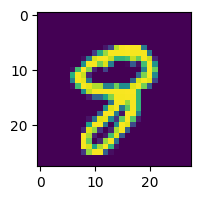

In [3]:
# Print example initial data and labels - randomly selected
plot_index = np.random.randint(0, len(x_train))
print(f"Item {plot_index}/{len(x_train)} from x_train")
print(f'Label: {y_train[plot_index]}')
plt.figure(figsize=(2, 2))
plt.imshow(x_train[plot_index])
plt.show()

+----+------------+----------------------+--------------------+
|    | Dataset    | Features Shape (x)   | Labels Shape (y)   |
+====+============+======================+====================+
|  0 | Training   | (48000, 28, 28)      | (48000,)           |
+----+------------+----------------------+--------------------+
|  1 | Validation | (12000, 28, 28)      | (12000,)           |
+----+------------+----------------------+--------------------+
|  2 | Test       | (10000, 28, 28)      | (10000,)           |
+----+------------+----------------------+--------------------+


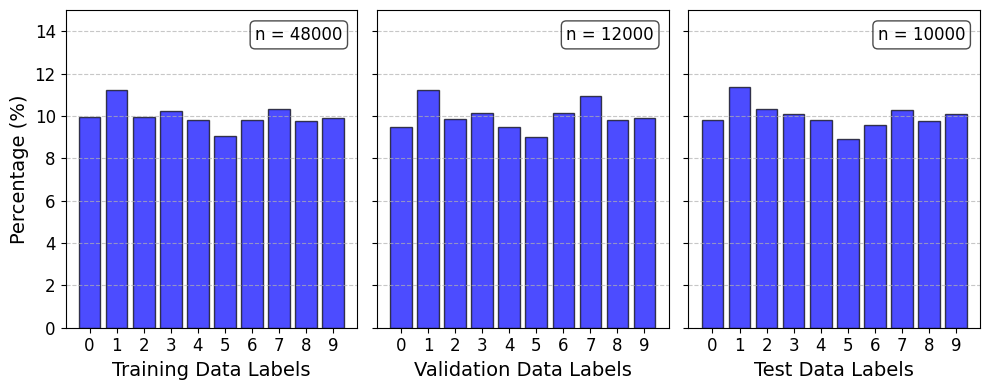

In [4]:
# Print the shape of the initial input data in table and plot distribution 
data_shapes_initial_inputs = pd.DataFrame({
    "Dataset": ["Training", "Validation", "Test"],
    "Features Shape (x)": [x_train.shape, x_val.shape, x_test.shape],
    "Labels Shape (y)": [y_train.shape, y_val.shape, y_test.shape]
})
print(tabulate(data_shapes_initial_inputs, headers='keys', tablefmt='grid'))

# Print a plot of the percentage distribution of the data 
# Calculate percentage distributions
train_label_percentages = np.bincount(y_train) / len(y_train) * 100
val_label_percentages = np.bincount(y_val) / len(y_val) * 100
test_label_percentages = np.bincount(y_test) / len(y_test) * 100

labels = np.arange(num_params)
num_train = len(y_train)
num_val = len(y_val)
num_test = len(y_test)

# Set up the axis
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

# Training Data Plot
axes[0].bar(labels, train_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel("Training Data Labels", fontsize=14)
axes[0].set_ylabel("Percentage (%)", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_xticks(labels)
axes[0].set_ylim(0, 15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].text(0.95, 0.95, f"n = {num_train}", transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Validation Data Plot
axes[1].bar(labels, val_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Validation Data Labels", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xticks(labels)
axes[1].set_ylim(0, 15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].text(0.95, 0.95, f"n = {num_val}", transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Test Data Plot
axes[2].bar(labels, test_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel("Test Data Labels", fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xticks(labels)
axes[2].set_ylim(0, 15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].text(0.95, 0.95, f"n = {num_test}", transform=axes[2].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [5]:
# Create v stack input data 
train_double_size = 100000
val_double_size = 15000
test_double_size = 15000

# Generate random indices for the double data set
# Vectorised sampling with replacement
train_double_indices =  [np.random.randint(0, x_train.shape[0], train_double_size), np.random.randint(0, x_train.shape[0], train_double_size)]

val_double_indices =  [np.random.randint(0, x_val.shape[0], val_double_size), np.random.randint(0, x_val.shape[0], val_double_size)]

test_double_indices =  [np.random.randint(0, x_test.shape[0], test_double_size), np.random.randint(0, x_test.shape[0], test_double_size)]


# Generate their corresponding images and labels at these indices

x_train_double = np.concatenate((x_train[train_double_indices[0]], x_train[train_double_indices[1]]), axis=1) 
y_train_double = np.add(y_train[train_double_indices[0]], y_train[train_double_indices[1]])

x_val_double = np.concatenate((x_val[val_double_indices[0]], x_val[val_double_indices[1]]), axis=1)
y_val_double = np.add(y_val[val_double_indices[0]], y_val[val_double_indices[1]])

x_test_double = np.concatenate((x_test[test_double_indices[0]], x_test[test_double_indices[1]]), axis=1)
y_test_double = np.add(y_test[test_double_indices[0]], y_test[test_double_indices[1]])


Item 17569/100000 from x_train
Label: 10


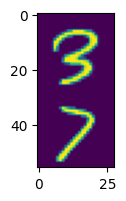

In [6]:
# Print example double data and labels - randomly selected
plot_index_double = np.random.randint(0, len(x_train_double))
print(f"Item {plot_index_double}/{len(x_train_double)} from x_train")
print(f'Label: {y_train_double[plot_index_double]}')
plt.figure(figsize=(2, 2))
plt.imshow(x_train_double[plot_index_double])
plt.show()

+----+------------+----------------------+--------------------+
|    | Dataset    | Features Shape (x)   | Labels Shape (y)   |
+====+============+======================+====================+
|  0 | Training   | (100000, 56, 28)     | (100000,)          |
+----+------------+----------------------+--------------------+
|  1 | Validation | (15000, 56, 28)      | (15000,)           |
+----+------------+----------------------+--------------------+
|  2 | Test       | (15000, 56, 28)      | (15000,)           |
+----+------------+----------------------+--------------------+


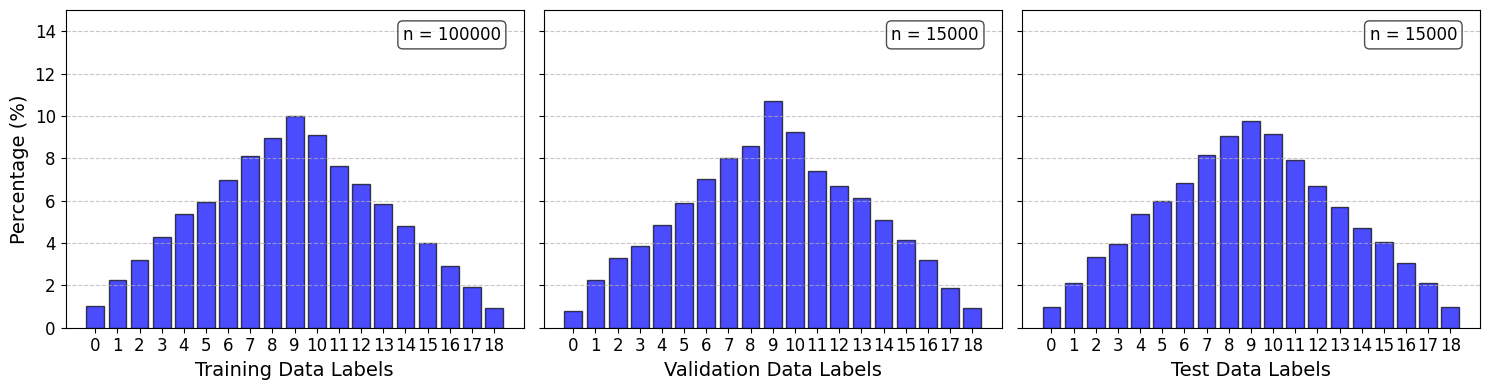

In [7]:
# Print the shape of the double input data in table and plot distribution 
num_params_double = len(np.unique(y_test_double))

# Print the shape of the data in table
data_shapes_double_inputs = pd.DataFrame({
    "Dataset": ["Training", "Validation", "Test"],
    "Features Shape (x)": [x_train_double.shape, x_val_double.shape, x_test_double.shape],
    "Labels Shape (y)": [y_train_double.shape, y_val_double.shape, y_test_double.shape]
})
print(tabulate(data_shapes_double_inputs, headers='keys', tablefmt='grid'))

# Print a plot of the percentage distribution of the data 
# Calculate percentage distributions
train_double_label_percentages = np.bincount(y_train_double) / len(y_train_double) * 100
val_double_label_percentages = np.bincount(y_val_double) / len(y_val_double) * 100
test_double_label_percentages = np.bincount(y_test_double) / len(y_test_double) * 100

labels = np.arange(num_params_double)
num_train_double = len(y_train_double)
num_val_double = len(y_val_double)
num_test_double = len(y_test_double)

# Set up the axis
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Training Data Plot
axes[0].bar(labels, train_double_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel("Training Data Labels", fontsize=14)
axes[0].set_ylabel("Percentage (%)", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_xticks(labels)
axes[0].set_ylim(0, 15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].text(0.95, 0.95, f"n = {num_train_double}", transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Validation Data Plot
axes[1].bar(labels, val_double_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Validation Data Labels", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xticks(labels)
axes[1].set_ylim(0, 15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].text(0.95, 0.95, f"n = {num_val_double}", transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Test Data Plot
axes[2].bar(labels, test_double_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel("Test Data Labels", fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xticks(labels)
axes[2].set_ylim(0, 15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].text(0.95, 0.95, f"n = {num_test_double}", transform=axes[2].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [8]:
# Convert the y labels to categorical labels
print(f"Data label (number): {y_train_double[10]}\n")

y_train_double = to_categorical(y_train_double, num_classes=num_params_double)
y_val_double = to_categorical(y_val_double, num_classes=num_params_double)
y_test_double = to_categorical(y_test_double, num_classes=num_params_double)

print(f"Becomes catagorised: {y_train_double[10]}")

Data label (number): 7

Becomes catagorised: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
input_shape = (x_train_double.shape[1], x_train_double.shape[2])
output_shape = y_train_double.shape[1]
print(input_shape)
# Optuna optimisation function
def objective(trial):
    # 5 hyperparameters to scan over
    num_layers = trial.suggest_int('num_layers', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.25, 0.5)
    starting_units = trial.suggest_int('starting_units', 600, 1000, log=True)  
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 6e-3, log=True)
    reduction_factor = trial.suggest_float('reduction_factor', 0.65, 0.85)  
    
    # Build the model
    model = Sequential()
    # Flatten the input data
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    
    units = starting_units
    for _ in range(num_layers):
        # Add Dense layer with L2 regularization
        model.add(Dense(units=units))
        # Add Batch Normalization
        model.add(BatchNormalization())
        # Add activation separately
        model.add(Activation('sigmoid'))
        # Add Dropout for regularization
        model.add(Dropout(rate=dropout_rate))
        # Reduce units for the next layer
        units = int(units * reduction_factor)

    model.add(Dense(output_shape, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(x_train_double, y_train_double, 
                        validation_data=(x_val_double, y_val_double),
                        epochs=7, 
                        batch_size=64, 
                        verbose=0)
    
    # Evaluate the model
    score = model.evaluate(x_test_double, y_test_double, verbose=0)
    accuracy = score[1]
    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name="Double_MNIST_Hyperparamater_Optimisation")

study.optimize(objective, n_trials=40)  

# Print the best trial
print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-12-06 17:06:26,511] A new study created in memory with name: Double_MNIST_Hyperparamater_Optimisation


(56, 28)


2024-12-06 17:06:26.525889: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-06 17:06:26.525918: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-06 17:06:26.525923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-06 17:06:26.525957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-06 17:06:26.525969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-06 17:06:27.670636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
[I 2024-12-06 17:08:41,143] Tri

Best trial:
 Value: 0.9319333434104919
 Params: 
    num_layers: 4
    dropout_rate: 0.2894562895352779
    starting_units: 861
    learning_rate: 0.004965311362206422
    batch_size: 64
    reduction_factor: 0.7979679441449881


In [10]:
# Create a table showing the top 6 best trails performed by optuna

# Extract the six best trials from the Optuna study
best_6_trials = study.trials_dataframe().nlargest(6, "value")

# Create a list of dictionaries to hold the trial results
best_6_results = []
for index, row in best_6_trials.iterrows():
    trial = study.trials[int(row['number'])]
    result = {
        'Trial': trial.number,
        'Value': trial.value,
        **trial.params  # Unpack hyperparameters
    }
    best_6_results.append(result)

# Convert to a DataFrame
best_results_df = pd.DataFrame(best_6_results)

# Convert to displayable table
table_best_6_trails = tabulate(best_results_df, headers='keys', tablefmt='grid')
print(table_best_6_trails)

+----+---------+----------+--------------+----------------+------------------+-----------------+--------------+--------------------+
|    |   Trial |    Value |   num_layers |   dropout_rate |   starting_units |   learning_rate |   batch_size |   reduction_factor |
+====+=========+==========+==============+================+==================+=================+==============+====================+
|  0 |       7 | 0.931933 |            4 |       0.289456 |              861 |      0.00496531 |           64 |           0.797968 |
+----+---------+----------+--------------+----------------+------------------+-----------------+--------------+--------------------+
|  1 |      26 | 0.9296   |            4 |       0.273036 |              946 |      0.00599939 |          128 |           0.784624 |
+----+---------+----------+--------------+----------------+------------------+-----------------+--------------+--------------------+
|  2 |      25 | 0.929133 |            3 |       0.274943 |          

In [11]:
# Build the best model over 10 epochs - with early stopping

# Extract the best parameters from optuna study
best_params = study.best_trial.params

num_layers = best_params['num_layers']
dropout_rate = best_params['dropout_rate']
starting_units = best_params['starting_units']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
reduction_factor = best_params['reduction_factor']

    
# Build the model
model_best = Sequential()
model_best.add(Input(shape=input_shape))
model_best.add(Flatten())

units = starting_units
for _ in range(num_layers):
    model_best.add(Dense(units=units, kernel_regularizer=None))
    model_best.add(BatchNormalization())  
    model_best.add(Activation('sigmoid'))
    model_best.add(Dropout(rate=dropout_rate))
    units = int(units * reduction_factor)

model_best.add(Dense(output_shape, activation='softmax'))
    
# Compile the model
model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         
    patience=3,                
    restore_best_weights=True 
)

# Train the 'best' model for 15 epoch
history_best = model_best.fit(
    x_train_double, y_train_double,
    validation_data=(x_val_double, y_val_double),
    epochs=15,
    callbacks=[early_stopping], # Add the early stopping callback
    batch_size=batch_size,
    verbose=1
)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - accuracy: 0.1796 - loss: 2.4409 - val_accuracy: 0.5785 - val_loss: 1.3434
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.5837 - loss: 1.3382 - val_accuracy: 0.8012 - val_loss: 0.6727
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.7669 - loss: 0.7918 - val_accuracy: 0.8746 - val_loss: 0.4233
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.8311 - loss: 0.5801 - val_accuracy: 0.8985 - val_loss: 0.3509
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.8625 - loss: 0.4725 - val_accuracy: 0.9105 - val_loss: 0.3207
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.8831 - loss: 0.3989 - val_accuracy: 0.9202 - val_loss: 0.2784
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accuracy: 0.9043 - loss: 0.3279 - val_accuracy: 0.9295 - val_loss: 0.2583
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.9156 -

In [12]:
# Save the results of best model in a Results folder - for reproducibility
# Save the whole model
model_best.save('Results/mnist_double_best_model.keras')

# Save just the weights
model_best.save_weights('Results/mnist_double_best_model_weights.weights.h5') 

# Save the training history as a JSON file
json.dump(history_best.history, open('Results/mnist_double_best_model_training_history.json', 'w'))

In [14]:
# Load back the model and evaluate it - for reproducibility
model_best_file = tf.keras.models.load_model('Results/mnist_double_best_model.keras')

score = model_best_file.evaluate(x_test_double, y_test_double, verbose=1)
print(f"Test Accuracy: {score[1]}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9502 - loss: 0.1858
Test Accuracy: 0.9503999948501587


In [15]:
# print the 'best models' summary
model_best_file.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_40 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 861)            │     1,350,909 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 861)            │         3,444 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_134 (Activation)     │ (None, 861)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 861)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 687)            │       592,194 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 687)            │         2,748 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_135 (Activation)     │ (None, 687)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 687)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 548)            │       377,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 548)            │         2,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_136 (Activation)     │ (None, 548)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 548)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 437)            │       239,913 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 437)            │         1,748 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_137 (Activation)     │ (None, 437)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 437)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 19)             │         8,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,725,352 (29.47 MB)

 Trainable params: 2,573,428 (9.82 MB)

 Non-trainable params: 5,066 (19.79 KB)

 Optimizer params: 5,146,858 (19.63 MB)

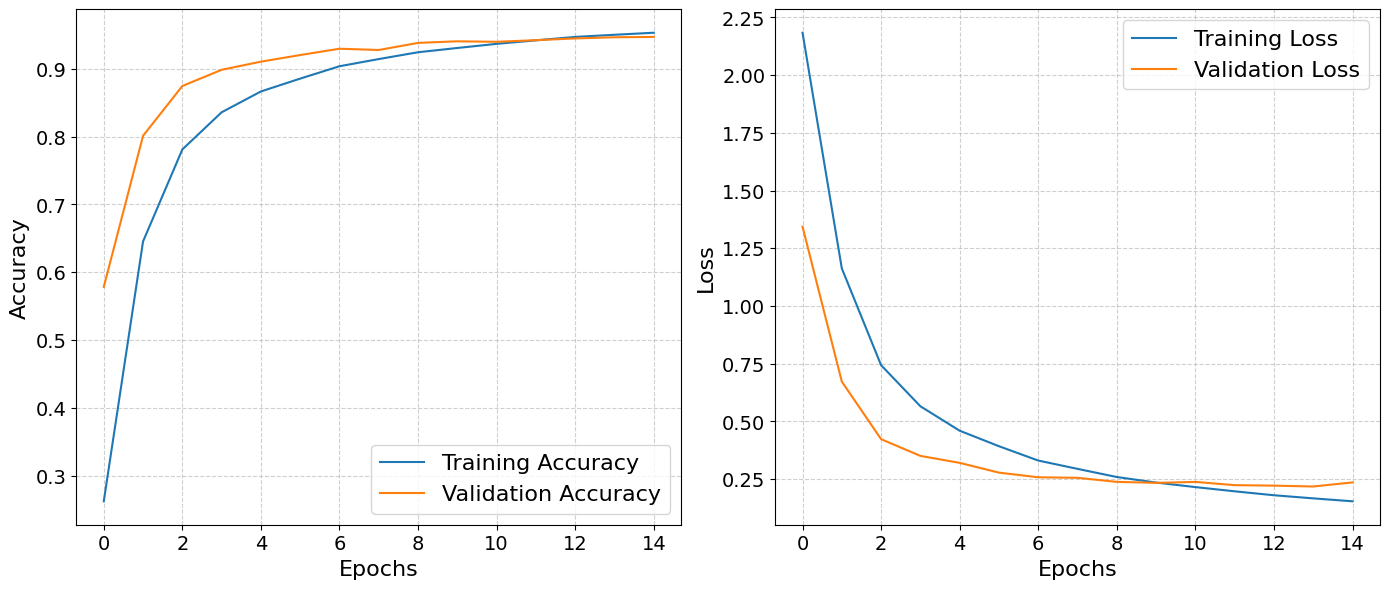

In [16]:
# Load the history from the saved JSON file
history_best_file = json.load(open('Results/mnist_double_best_model_training_history.json', 'r'))

font_size = 16
tick_size = 14
title_size = 18
fig_size = (14, 6)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=fig_size) 

# Plot Training and Validation Accuracy against epochs
axes[0].plot(history_best_file['accuracy'], label='Training Accuracy')
axes[0].plot(history_best_file['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epochs', fontsize=font_size)
axes[0].set_ylabel('Accuracy', fontsize=font_size)
axes[0].legend(fontsize=font_size)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=tick_size)

# Plot Training and Validation Loss against epochs
axes[1].plot(history_best_file['loss'], label='Training Loss')
axes[1].plot(history_best_file['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epochs', fontsize=font_size)
axes[1].set_ylabel('Loss', fontsize=font_size)
axes[1].legend(fontsize=font_size)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.show()